In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
from xgboost import XGBClassifier

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [62]:
def show_data_info(data: pd.DataFrame):
    print("Data Information:")
    print(data.info())
    print("\nFirst 5 Rows of the Data:")
    print(data.head())
    print("\nStatistical Summary of the Data:")
    print(data.describe())
def normalize_column_names(data: pd.DataFrame) -> pd.DataFrame:
    data.columns = [col.strip().lower().replace(' ', '_') for col in data.columns]
    return data

In [63]:
df = normalize_column_names(df)
show_data_info(df)
df_test = normalize_column_names(df_test)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

First 5 Rows of the Data:
   passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5

In [64]:
def clean_data(df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
    """Aplica limpieza y feature engineering reproducible a un DataFrame del Titanic.

    - Normaliza nombres de columnas
    - Maneja `cabin` (has_cabin, number_cabin, type_cabin)
    - Crea dummies de `embarked`
    - Convierte `sex` a numérico
    - Crea `is_child`, `age_not_known` (1 si falta la edad)
    - Extrae `title` y agrupa títulos raros
    - Imputa `age` por mediana por grupo (sex, pclass, title) y luego global
    - Crea `family_size`
    - Imputa `fare` si es test y falta

    Retorna el DataFrame modificado.
    """
    df = df.copy()
    # Normalizar columnas (idempotente)
    df = normalize_column_names(df)

    # Cabin
    if 'cabin' in df.columns:
        df['has_cabin'] = df['cabin'].notnull().astype(int)
        df['cabin'] = df['cabin'].fillna('Unknown')
        df['number_cabin'] = df['cabin'].apply(lambda x: 0 if (not isinstance(x, str) or x == 'Unknown') else len(x.split(' ')))
    else:
        df['has_cabin'] = 0
        df['number_cabin'] = 0
        df['cabin'] = 'Unknown'

    # Embarked one-hot (si existe)
    if 'embarked' in df.columns:
        df = pd.get_dummies(df, columns=['embarked'], drop_first=True)

    # Sex numeric
    if 'sex' in df.columns:
        df['sex'] = df['sex'].map({'male': 0, 'female': 1})

    # Age related features
    if 'age' in df.columns:
        df['is_child'] = (df['age'] < 12).astype(int)
        # age_not_known = 1 when age is NOT known (True if null)
        df['age_not_known'] = df['age'].isnull().astype(int)

    # Index and title
    df = df.reset_index(drop=True)
    if 'name' in df.columns:
        df['title'] = df['name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
        rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Capt']
        df['title'] = df['title'].replace(rare_titles, 'Rare')
    else:
        df['title'] = 'Unknown'

    # Imputar age por mediana por grupo y luego global
    if 'age' in df.columns:
        try:
            df['age'] = df['age'].fillna(df.groupby(['sex', 'pclass', 'title'])['age'].transform('median'))
        except Exception:
            # en caso de que no existan las columnas de agrupación, caer a la mediana global
            pass
        df['age'] = df['age'].fillna(df['age'].median())

    # Family size
    if {'sibsp', 'parch'}.issubset(df.columns):
        df['family_size'] = df['sibsp'] + df['parch'] + 1
    else:
        df['family_size'] = 1

    # Type cabin (map letter to numeric, 0 si desconocido)
    mapping = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':8,'0':0}

# opción recomendada: extraer y mapear en mayúsculas, luego rellenar NaN con 0
    if 'cabin' in df.columns:
        df['type_cabin'] = df['cabin'].astype(str).str.extract(r'([A-Za-z])', expand=False).str.upper()
        df['type_cabin'] = df['type_cabin'].map(mapping).fillna(0).astype(int)
    else:
        df['type_cabin'] = 0

    # Para el conjunto de test, asegurarse de imputar fare si falta
    if not is_train and 'fare' in df.columns:
        df['fare'] = df['fare'].fillna(df['fare'].median())

    return df

# Llamadas ejemplares (reemplazaremos las operaciones manuales existentes con estas llamadas)
# df = clean_data(df, is_train=True)
# df_test = clean_data(df_test, is_train=False)


In [65]:
def find_missing_values(df: pd.DataFrame, name: str = 'data', top_n: int = None) -> pd.DataFrame:
    """Devuelve un DataFrame con columnas, conteos y porcentajes de valores faltantes.

    Args:
        df: DataFrame a analizar.
        name: etiqueta para identificar el DataFrame en prints (opcional).
        top_n: si se especifica, retorna solo las top_n columnas con más NAs.

    Returns:
        DataFrame ordenado por `missing_count` descendente con columnas:
        ['column', 'missing_count', 'missing_pct']
    """
    total = len(df)
    missing_counts = df.isnull().sum()
    missing_pct = (missing_counts / total) * 100
    missing_df = pd.DataFrame({
        'column': missing_counts.index,
        'missing_count': missing_counts.values,
        'missing_pct': missing_pct.values
    })
    missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_count', ascending=False).reset_index(drop=True)
    if top_n is not None:
        missing_df = missing_df.head(top_n)
    return missing_df

# Ejemplo de uso:
# print(find_missing_values(df_test, name='df_test'))
# print(find_missing_values(df, name='df'))


In [36]:
# ===============================================
# LIMPIEZA BÁSICA DE DATOS Y FORMATO
# ===============================================

print("=== INFORMACIÓN INICIAL DEL DATASET ===")
print(f"Forma del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

# 1. REVISAR VALORES FALTANTES
print("\n=== VALORES FALTANTES EN TEST ===")
missing_test = find_missing_values(df_test, name='df_test')
print(missing_test)

print("\n=== VALORES FALTANTES EN TRAIN ===")
missing_train = find_missing_values(df, name='df')
print(missing_train)


=== INFORMACIÓN INICIAL DEL DATASET ===
Forma del dataset: (891, 20)
Número de filas: 891
Número de columnas: 20

=== VALORES FALTANTES EN TEST ===
       column  missing_count  missing_pct
0         sex            418   100.000000
1  type_cabin            327    78.229665

=== VALORES FALTANTES EN TRAIN ===
       column  missing_count  missing_pct
0         sex            891   100.000000
1  type_cabin            687    77.104377


In [66]:
# Aplicar limpieza reproducible centralizada
# La función `clean_data` realiza normalización de columnas, imputaciones y creación de features.
df = clean_data(df, is_train=True)
# Aplicar limpieza reproducible al conjunto de test
df_test = clean_data(df_test, is_train=False)

# Mostrar información del dataset de test
show_data_info(df_test)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    418 non-null    int64  
 1   pclass         418 non-null    int64  
 2   name           418 non-null    object 
 3   sex            418 non-null    int64  
 4   age            418 non-null    float64
 5   sibsp          418 non-null    int64  
 6   parch          418 non-null    int64  
 7   ticket         418 non-null    object 
 8   fare           418 non-null    float64
 9   cabin          418 non-null    object 
 10  has_cabin      418 non-null    int64  
 11  number_cabin   418 non-null    int64  
 12  embarked_Q     418 non-null    bool   
 13  embarked_S     418 non-null    bool   
 14  is_child       418 non-null    int64  
 15  age_not_known  418 non-null    int64  
 16  title          418 non-null    object 
 17  family_size    418 non-null    int64

In [67]:
# Search for missing values again after cleaning
# Writing all in english
print("\n=== Values missing after cleaning in TEST ===")
print(find_missing_values(df_test, name='df_test'))


=== Values missing after cleaning in TEST ===
Empty DataFrame
Columns: [column, missing_count, missing_pct]
Index: []


In [39]:
#Code Ad hoc for the missing values in the test set
print(df_test[df_test['type_cabin'].isnull()].head())

Empty DataFrame
Columns: [passengerid, pclass, name, sex, age, sibsp, parch, ticket, fare, cabin, has_cabin, number_cabin, embarked_q, embarked_s, is_child, age_not_known, title, family_size, type_cabin]
Index: []


In [11]:
#Check Bad data
print("\n=== REVISIÓN DE DATOS INCORRECTOS O ATÍPICOS ===")
print("Revisando la columna 'age' para valores negativos o mayores a 100:")
# Search a data with values less than 0 or greater than 100
bad_data_age = df[(df['age'] < 0) | (df['age'] > 100)]
print(bad_data_age)



=== REVISIÓN DE DATOS INCORRECTOS O ATÍPICOS ===
Revisando la columna 'age' para valores negativos o mayores a 100:
Empty DataFrame
Columns: [passengerid, survived, pclass, name, sex, age, sibsp, parch, ticket, fare, cabin, has_cabin, number_cabin, embarked_Q, embarked_S]
Index: []


In [12]:
def check_is_negative(data: pd.DataFrame, column: str) -> bool:
    """Check for negative values in a specified column of the DataFrame."""
    bad_data = data[data[column] < 0]
    # If there are negative values, return True
    return bad_data.shape[0] > 0

def check_is_greater_than(data: pd.DataFrame, column: str, value: int) -> bool:
    """Check for values greater than a specified value in a specified column of the DataFrame."""
    bad_data = data[data[column] > value]
    return bad_data.shape[0] > 0

def normaliza_gender(data: pd.DataFrame, column: str) -> pd.DataFrame:
    data[column] = data[column].str.lower()
    return data

In [13]:
# Must be check the Male/Female grammar
if  0 < len(df['sex'].unique()) > 2:
  print("#Error in the sex")

if check_is_negative(df, 'age'):
  print("Error: There are negative values in the 'age' column.")
show_data_info(df)


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passengerid   891 non-null    int64  
 1   survived      891 non-null    int64  
 2   pclass        891 non-null    int64  
 3   name          891 non-null    object 
 4   sex           891 non-null    object 
 5   age           714 non-null    float64
 6   sibsp         891 non-null    int64  
 7   parch         891 non-null    int64  
 8   ticket        891 non-null    object 
 9   fare          891 non-null    float64
 10  cabin         891 non-null    object 
 11  has_cabin     891 non-null    int64  
 12  number_cabin  891 non-null    int64  
 13  embarked_Q    891 non-null    bool   
 14  embarked_S    891 non-null    bool   
dtypes: bool(2), float64(2), int64(7), object(4)
memory usage: 92.4+ KB
None

First 5 Rows of the Data:
   passengerid  survived  pclass  \
0     

In [68]:
print(df_test.info())
print(df_test.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    418 non-null    int64  
 1   pclass         418 non-null    int64  
 2   name           418 non-null    object 
 3   sex            418 non-null    int64  
 4   age            418 non-null    float64
 5   sibsp          418 non-null    int64  
 6   parch          418 non-null    int64  
 7   ticket         418 non-null    object 
 8   fare           418 non-null    float64
 9   cabin          418 non-null    object 
 10  has_cabin      418 non-null    int64  
 11  number_cabin   418 non-null    int64  
 12  embarked_Q     418 non-null    bool   
 13  embarked_S     418 non-null    bool   
 14  is_child       418 non-null    int64  
 15  age_not_known  418 non-null    int64  
 16  title          418 non-null    object 
 17  family_size    418 non-null    int64  
 18  type_cabin

In [69]:
# Convertir / asegurar algunas transformaciones ya realizadas en clean_data
# Nota: la mayoría de estas transformaciones ya las hace `clean_data`. Aquí sólo corregimos pequeñas inconsistencias
# Asegurarse de que `age_not_known` tiene la semántica correcta (1 si falta edad)
if 'age' in df.columns:
    df['age_not_known'] = df['age'].isnull().astype(int)

if 'age' in df_test.columns:
    df_test['age_not_known'] = df_test['age'].isnull().astype(int)

# Reiniciar índices (ya lo hace clean_data, pero por seguridad)
df = df.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Crear copia limpia para modelado
df_clean = df.copy()
df_clean_test = df_test.copy()

In [70]:
print(df_test['type_cabin'].value_counts())
# Buscar los valores NULL
print(df_test['type_cabin'].isnull().sum())
#Imprimit los 10 valores primero faltantates
print(df_test[df_test['type_cabin'].isnull()].head(10))
print("   \n ")
print(df_test.head(10))

type_cabin
0    327
3     35
2     18
4     13
5      9
6      8
1      7
7      1
Name: count, dtype: int64
0
Empty DataFrame
Columns: [passengerid, pclass, name, sex, age, sibsp, parch, ticket, fare, cabin, has_cabin, number_cabin, embarked_Q, embarked_S, is_child, age_not_known, title, family_size, type_cabin]
Index: []
   
 
   passengerid  pclass                                          name  sex  \
0          892       3                              Kelly, Mr. James    0   
1          893       3              Wilkes, Mrs. James (Ellen Needs)    1   
2          894       2                     Myles, Mr. Thomas Francis    0   
3          895       3                              Wirz, Mr. Albert    0   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)    1   
5          897       3                    Svensson, Mr. Johan Cervin    0   
6          898       3                          Connolly, Miss. Kate    1   
7          899       2                  Caldwell, Mr.

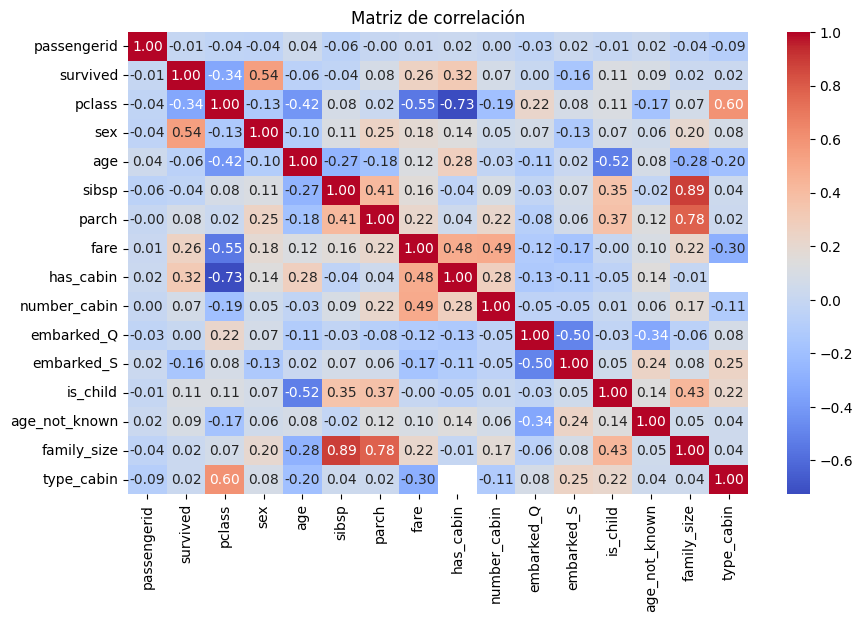

In [16]:
# Calculate the matrix of correlation
corr = df.corr(numeric_only=True)  # must ensure to use only numeric columns

# Viewalize in heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

In [71]:
print( df.groupby(['sex','pclass','title'])['age'].describe())

                   count       mean        std    min     25%   50%    75%  \
sex pclass title                                                             
0   1      Don       1.0  40.000000        NaN  40.00  40.000  40.0  40.00   
           Master    3.0   5.306667   5.165475   0.92   2.460   4.0   7.50   
           Mr      107.0  41.285047  12.758850  17.00  33.500  40.0  48.00   
           Rare     10.0  49.700000  10.893933  32.00  44.250  50.0  55.00   
           Sir       1.0  49.000000        NaN  49.00  49.000  49.0  49.00   
    2      Master    9.0   2.258889   2.342634   0.67   0.830   1.0   3.00   
           Mr       91.0  32.593407  11.255347  16.00  25.000  31.0  36.00   
           Rare      8.0  42.000000  14.020393  23.00  27.750  46.5  54.00   
    3      Master   28.0   5.157857   3.351499   0.42   2.750   4.0   8.25   
           Mr      319.0  27.956113   8.967689  11.00  22.500  26.0  30.25   
1   1      Miss     46.0  30.000000  12.708702   2.00  21.250  3

In [72]:
print(find_missing_values(df, name='df'))

Empty DataFrame
Columns: [column, missing_count, missing_pct]
Index: []


In [73]:
df_clean = df.copy()
df_clean_test = df_test.copy()

In [74]:
print(df_clean.describe())

       passengerid    survived      pclass         sex         age  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642    0.352413   29.150584   
std     257.353842    0.486592    0.836071    0.477990   13.504989   
min       1.000000    0.000000    1.000000    0.000000    0.420000   
25%     223.500000    0.000000    2.000000    0.000000   21.000000   
50%     446.000000    0.000000    3.000000    0.000000   26.000000   
75%     668.500000    1.000000    3.000000    1.000000   36.750000   
max     891.000000    1.000000    3.000000    1.000000   80.000000   

            sibsp       parch        fare   has_cabin  number_cabin  \
count  891.000000  891.000000  891.000000  891.000000    891.000000   
mean     0.523008    0.381594   32.204208    0.228956      0.267116   
std      1.102743    0.806057   49.693429    0.420397      0.547134   
min      0.000000    0.000000    0.000000    0.000000      0.000000   
25%      0.000

In [76]:
# Variables predictoras (X) y variable objetivo (y)
columns_important = ['sex', 'age', 'fare', 'has_cabin', 'embarked_q', 'embarked_s', 'is_child', 'number_cabin', 'pclass', 'sibsp' ,'parch','age_not_known' ,'family_size']
x = df_clean[columns_important]
y = df_clean['survived']

x_test = df_clean_test[columns_important]
# y_test = df_clean_test['survived']

# Dividir en train y test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


KeyError: "['embarked_q', 'embarked_s'] not in index"

In [56]:
# Crear el modelo
tree_clf = DecisionTreeClassifier(
    criterion='gini',      # o 'entropy'
    max_depth=4,           # limitar profundidad (para evitar overfitting)
    random_state=42
)

# Entrenar
tree_clf.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [57]:
y_pred = tree_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.7486033519553073

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.72      0.94      0.81       105
           1       0.85      0.47      0.61        74

    accuracy                           0.75       179
   macro avg       0.79      0.71      0.71       179
weighted avg       0.77      0.75      0.73       179



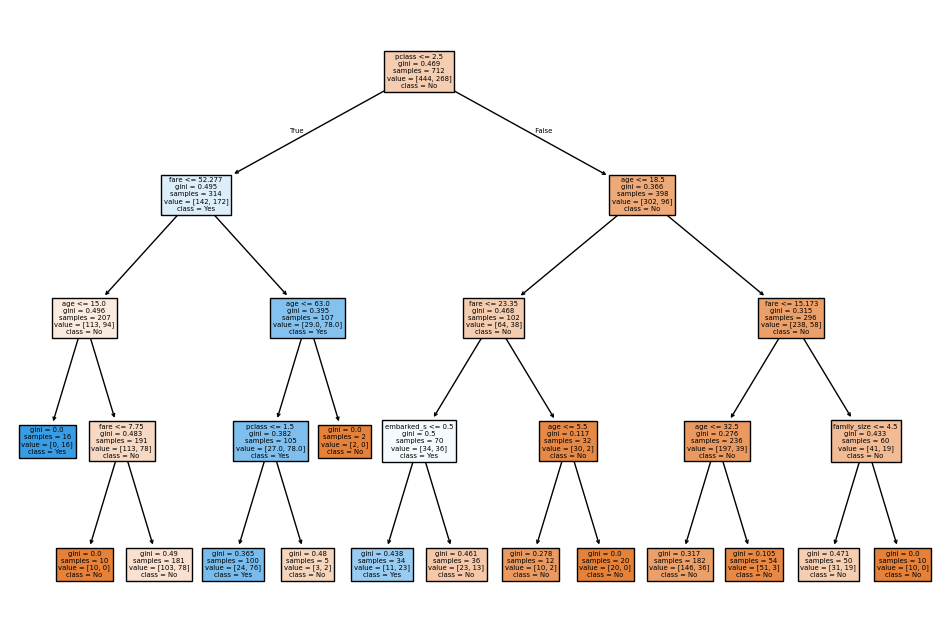

In [47]:
plt.figure(figsize=(12,8))
plot_tree(tree_clf, feature_names=x.columns, class_names=['No', 'Yes'], filled=True)
plt.show()


In [58]:
rf = RandomForestClassifier(n_estimators=300, max_depth=8, max_features='sqrt', random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(rf, x, y, cv=cv, scoring='accuracy')
print(scores.mean())

0.77328479065972


In [59]:
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(gb, x, y, cv=cv, scoring='accuracy')
print(scores.mean())
# Entrenar
gb.fit(X_train, y_train)
# Test model with x_test
y_pred_gb = gb.predict(x_test)
print(y_pred_gb)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\ensemble\_gb.py", line 658, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<4 lines>...
        multi_output=True,
        ^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 1105, in check_array
    _assert_all_finite(
    ~~~~~~~~~~~~~~~~~~^
        array,
        ^^^^^^
    ...<2 lines>...
        allow_nan=ensure_all_finite == "allow-nan",
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<4 lines>...
        input_name=input_name,
        ^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\fenic\Kaggle\titanic\venv\Lib\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [27]:

xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X, y, cv=cv, scoring='accuracy')
print(scores.mean())


0.8383403427280147


In [28]:
lgb = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=31, random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(lgb, X, y, cv=cv, scoring='accuracy')
print(scores.mean())

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores_l = cross_val_score(lr, X, y, cv=cv, scoring='accuracy')

In [30]:
print(scores_l.mean())

0.8058565061829137


In [31]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
LogisticRegression(penalty='l2')  # Ridge
LogisticRegression(penalty='l1')  # Lasso

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores_svc = cross_val_score(svm, x, y, cv=cv, scoring='accuracy')
print(scores_svc.mean())

0.6823677107526207


In [ ]:
# Test 
print("=== TEST ===")
# Con el mejor modelo 
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
cv = StratifiedKFold(5, shuffle=True, random_state=42)

scores = cross_val_score(gb, X, y, cv=cv, scoring='accuracy')
print(scores.mean())

0.8058565061829137
